## Import

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import random
import os, math
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(777) # Seed 고정

### train.csv [파일]
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


### test.csv [파일]
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


### sample_submission.csv [파일] - 제출 양식
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## Data Load

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/datasets/aimers/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/datasets/aimers/test.csv')

In [7]:
train_df.index = pd.to_datetime(train_df["TIMESTAMP"])
test_df.index = pd.to_datetime(test_df["TIMESTAMP"])

train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-06-13 05:14:00,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
2022-06-13 05:22:00,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2022-06-13 05:30:00,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
2022-06-13 05:39:00,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
2022-06-13 05:47:00,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [8]:
del_list = []
for i in range(6, 2880):
    if train_df.iloc[:, i].nunique() == 0:
        del_list.append(train_df.columns[i])
        
print(del_list)

['X_934', 'X_935', 'X_936', 'X_937', 'X_2628', 'X_2629', 'X_2630', 'X_2631', 'X_2632', 'X_2633', 'X_2634', 'X_2635', 'X_2636', 'X_2637', 'X_2638', 'X_2639', 'X_2640', 'X_2641', 'X_2642', 'X_2643', 'X_2644', 'X_2645', 'X_2646', 'X_2647', 'X_2648', 'X_2649', 'X_2650', 'X_2651', 'X_2652', 'X_2653', 'X_2654', 'X_2655', 'X_2656', 'X_2657', 'X_2658', 'X_2659', 'X_2660', 'X_2661', 'X_2662', 'X_2663', 'X_2664', 'X_2665', 'X_2666', 'X_2667', 'X_2668', 'X_2669', 'X_2670', 'X_2671', 'X_2672', 'X_2673', 'X_2674', 'X_2675', 'X_2676', 'X_2677', 'X_2678', 'X_2679', 'X_2680', 'X_2681', 'X_2682', 'X_2683', 'X_2684', 'X_2685', 'X_2686', 'X_2687', 'X_2688', 'X_2689', 'X_2690', 'X_2691', 'X_2692', 'X_2693', 'X_2694', 'X_2695', 'X_2696', 'X_2697', 'X_2698', 'X_2699', 'X_2838', 'X_2844', 'X_2872', 'X_2873', 'X_2874']


In [9]:
train_df.drop(columns=del_list, inplace=True)
test_df.drop(columns=del_list, inplace=True)

In [10]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [11]:
print(len(train_y))

598


## Data Pre-processing

In [12]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [13]:
from sklearn.preprocessing import RobustScaler

train_robust = train_x.iloc[:, 2:]

robust_scaler = RobustScaler()
fitted = robust_scaler.fit(train_robust)

train_robust = robust_scaler.transform(train_robust)
train_robust = pd.DataFrame(train_robust, columns=train_x.iloc[:, 2:].columns, index=train_x.index)
train_scaled = pd.concat([train_x.iloc[:, 0:2], train_robust], axis=1)

train_scaled.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2875
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-06-13 05:14:00,T050304,A_31,-1.0,-0.957895,0.0,-1.0,-1.0,0.0,-0.9,-1.0,...,0.997396,0.997188,1.000000,39.34,40.89,32.56,34.09,77.77,0.0,0.0
2022-06-13 05:22:00,T050307,A_31,-1.0,-0.957895,0.0,-1.0,-1.0,0.0,-0.9,-1.0,...,0.997396,0.995670,1.000000,38.89,42.82,43.92,35.34,72.55,0.0,0.0
2022-06-13 05:30:00,T050304,A_31,-1.0,-0.957895,0.0,-1.0,-1.0,0.0,-0.9,-1.0,...,0.997396,0.994547,1.000000,39.19,36.65,42.47,36.53,78.35,0.0,0.0
2022-06-13 05:39:00,T050307,A_31,-1.0,-0.957895,0.0,-1.0,-1.0,0.0,-0.9,-1.0,...,1.000000,0.999604,1.000000,37.74,39.17,52.17,30.58,71.78,0.0,0.0
2022-06-13 05:47:00,T050304,A_31,-1.0,-0.957895,0.0,-1.0,-1.0,0.0,-0.9,-1.0,...,0.997396,0.994631,0.997167,38.70,41.89,46.93,33.09,76.97,0.0,0.0


In [14]:
test_df_robust = test_x.iloc[:, 2:]
test_df_robust = robust_scaler.transform(test_df_robust)
test_df_robust = pd.DataFrame(test_df_robust, columns=test_x.iloc[:, 2:].columns, index=test_x.index)

In [15]:
test_x_robust = pd.concat([test_x.iloc[:, 0:2], test_df_robust], axis=1)

test_x_robust.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2875
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-09-09 02:01:00,T100306,T_31,0.0,0.031579,0.0,0.0,0.0,0.0,0.12,0.0,...,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 02:09:00,T100304,T_31,0.0,0.021053,0.0,0.0,0.1,0.0,0.00,0.0,...,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 08:42:00,T100304,T_31,0.0,0.042105,0.0,0.0,0.1,0.0,0.00,0.0,...,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 10:56:00,T010305,A_31,-1.0,-0.957895,0.0,-1.0,-1.0,0.0,-0.90,-1.0,...,1.216146,1.202682,1.1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 11:04:00,T010306,A_31,-1.0,-0.957895,0.0,-1.0,-1.0,0.0,-0.90,-1.0,...,1.210938,1.200026,1.1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_scaled[i] = le.transform(train_scaled[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x_robust[i] = le.transform(test_x_robust[i]) 
print('Done.')

Done.


In [17]:
train_x_robust = train_scaled.iloc[:math.floor(len(train_scaled)*0.9),]
val_x_robust = train_scaled.iloc[math.floor(len(train_scaled)*0.9):,]

train_y_robust = train_y.iloc[:math.floor(len(train_y)*0.9),]
val_y_robust = train_y.iloc[math.floor(len(train_y)*0.9):,]

## Classification Model Fit

In [18]:
# clf = XGBClassifier(tree_method="gpu_hist",
#                     gpu_id=0,
#                     gamma=3,
#                     colsample_bytree=0.7,
#                     reg_lambda=1,
#                     random_state=777)

# params = {
#     "max_depth": range(5, 11),
#     "n_estimators": range(10, 31, 5),
#     "learning_rate": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05],
#     "max_leaves": range(5, 11, 2)
# }

# grid = GridSearchCV(estimator=clf, param_grid=params, cv=3)

# grid.fit(train_x_robust, train_y_robust)

# best_params = grid.best_params_

# print(best_params)

In [36]:
# clf_best = XGBClassifier(tree_method="gpu_hist",
#                          gpu_id=0,
#                          gamma=3,
#                          colsample_bytree=0.7,
#                          max_depth=best_params["max_depth"], 
#                          n_estimators=best_params["n_estimators"], 
#                          learning_rate=best_params["learning_rate"], 
#                          max_leaves=best_params["max_leaves"],
#                          reg_lambda=1,
#                          random_state=777)

clf_best = XGBClassifier(tree_method="gpu_hist",
                         gpu_id=0,
                         gamma=3,
                         colsample_bytree=0.6,
                        #  max_depth=2000, 
                        #  n_estimators=1000, 
                         learning_rate=0.001, 
                        #  max_leaves=10000,
                         reg_alpha=1,
                         random_state=777)

clf_best.fit(train_x_robust, train_y_robust,
            #  early_stopping_rounds=10,
             eval_set=[(val_x_robust, val_y_robust)],
            #  verbose=0
             )

[0]	validation_0-merror:0.633333
[1]	validation_0-merror:0.633333
[2]	validation_0-merror:0.633333
[3]	validation_0-merror:0.65
[4]	validation_0-merror:0.65
[5]	validation_0-merror:0.65
[6]	validation_0-merror:0.633333
[7]	validation_0-merror:0.633333
[8]	validation_0-merror:0.6
[9]	validation_0-merror:0.583333
[10]	validation_0-merror:0.6
[11]	validation_0-merror:0.566667
[12]	validation_0-merror:0.583333
[13]	validation_0-merror:0.583333
[14]	validation_0-merror:0.583333
[15]	validation_0-merror:0.583333
[16]	validation_0-merror:0.583333
[17]	validation_0-merror:0.583333
[18]	validation_0-merror:0.583333
[19]	validation_0-merror:0.583333
[20]	validation_0-merror:0.583333
[21]	validation_0-merror:0.583333
[22]	validation_0-merror:0.583333
[23]	validation_0-merror:0.583333
[24]	validation_0-merror:0.583333
[25]	validation_0-merror:0.583333
[26]	validation_0-merror:0.583333
[27]	validation_0-merror:0.583333
[28]	validation_0-merror:0.583333
[29]	validation_0-merror:0.583333
[30]	validat

XGBClassifier(colsample_bytree=0.6, gamma=3, gpu_id=0, learning_rate=0.001,
              objective='multi:softprob', random_state=777, reg_alpha=1,
              tree_method='gpu_hist')

## Inference

In [37]:
train_preds = clf_best.predict(val_x_robust)

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("정확도:", accuracy_score(val_y_robust, train_preds))
print("재현율:", recall_score(val_y_robust, train_preds, average='macro'))
print("정밀도:", precision_score(val_y_robust, train_preds, average='macro'))
print("F1 score:", f1_score(val_y_robust, train_preds, average='macro'))

정확도: 0.43333333333333335
재현율: 0.32098765432098764
정밀도: 0.14689265536723164
F1 score: 0.20155038759689922


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


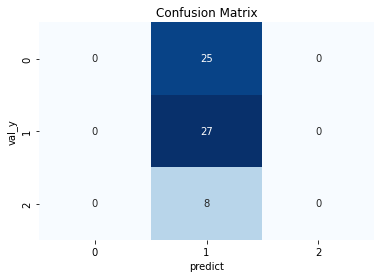

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_y_robust, train_preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("val_y")
plt.xlabel("predict")
plt.show()

In [63]:
preds = clf_best.predict(test_x_robust)
print('Done.')

Done.


## Submit

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/datasets/aimers/sample_submission.csv')

In [ ]:
submit['Y_Class'] = preds

In [ ]:
submit.to_csv('/content/drive/MyDrive/datasets/aimers/baseline_submission.csv', index=False)